# OLS Linear Regression using numpy

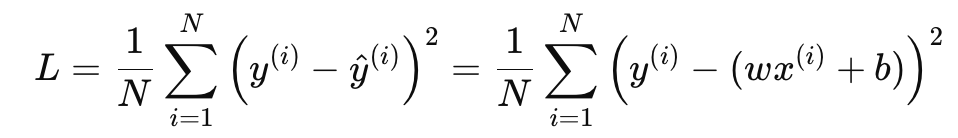

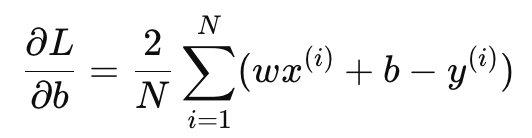

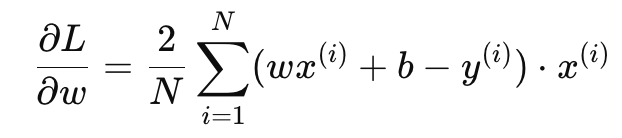

In [51]:
import numpy as np

class LinearRegression():
    def __init__(self, learning_rate=0.01, epochs=1000, poly_degree=None, tolerance=1e-4, l2_penalty=0.0):
        self.alpha = learning_rate  # Learning rate
        self.epochs = epochs  # Number of iterations
        self.weights = None  # Weights (excluding bias)
        self.bias = 0  # Bias term
        self.poly_degree = poly_degree  # Flag for polynomial regression
        self.loss_history = []
        self.tolerance = tolerance
        self.l2_penalty = l2_penalty  # L2 regularization penalty
        
    def _polynomial_features(self, X):
        """
        Transforms the input matrix X to include polynomial features up to the specified degree.
        """
        if self.poly_degree:
            X_poly = X
            for i in range(2, self.poly_degree + 1):  # Add X^2, X^3, ..., X^degree
                X_poly = np.column_stack([X_poly, X ** i])  # Add each power of X as a new feature
            return X_poly
        else:
            return X

    def fit(self, X, y):
        assert not np.isnan(X).any(), "Input X contains NaNs"
        assert not np.isnan(y).any(), "Input y contains NaNs"
        assert not np.isinf(X).any(), "Input X contains Infs"
        assert not np.isinf(y).any(), "Input y contains Infs"
        
        
        N, n_features = X.shape
        
        # Apply polynomial transformation if poly_degree is provided
        X_poly = self._polynomial_features(X)

        # Initialize weights and bias
        self.weights = np.zeros((X_poly.shape[1], 1))  # Update to match the new number of features
        self.bias = 0
        
        y = y.reshape(-1, 1)  # Ensure y is a column vector
        
        best_loss = float('inf')
        patience = 20
        no_improve_epochs = 0

        # Gradient Descent
        for epoch in range(self.epochs):
            # Make predictions
            y_pred = np.dot(X_poly, self.weights) + self.bias # Linear prediction - np.dot(X, self.weights) + self.bias
            error = y_pred - y

            # Compute gradients
            gradient_w = (2 / N) * (np.dot(X_poly.T, error) + self.l2_penalty * self.weights) #gradient_w = (2 / N) * np.dot(X_poly.T, error)
            gradient_b = (2 / N) * np.sum(error)   # equivalent to 2 * np.mean(y_pred - y)
            
            # Update weights and bias
            #self.weights = self.weights - self.alpha * gradient_w
            #self.bias = self.bias - self.alpha * gradient_b
            
            # Clip gradients
            gradient_w = np.clip(gradient_w, -1e2, 1e2)
            gradient_b = np.clip(gradient_b, -1e2, 1e2)

            # Safe update
            update_w = self.alpha * gradient_w  
            update_b = self.alpha * gradient_b
            update_w = np.nan_to_num(update_w)
            update_b = np.nan_to_num(update_b)

            self.weights = self.weights - update_w
            self.bias = self.bias - update_b
            
            loss = np.mean(error ** 2)
            
            self.loss_history.append(loss)
            
            # Early stopping logic
            if loss + self.tolerance < best_loss:
                best_loss = loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        return self

    def predict(self, X):
        # Apply polynomial transformation for prediction
        X_poly = self._polynomial_features(X)
        
        # Make predictions 
        return np.dot(X_poly, self.weights) + self.bias

In [52]:
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

n_samples = 1000
n_outliers = 50

X, y, coef = datasets.make_regression(
    n_samples=n_samples,
    n_features=1,
    n_informative=1,
    noise=10,
    coef=True,
    random_state=0,
)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)


Epoch 0, Loss: 6336.4868
Epoch 10, Loss: 4962.7304
Epoch 20, Loss: 3871.0162
Epoch 30, Loss: 3168.5584
Epoch 40, Loss: 2767.5690
Epoch 50, Loss: 2537.6432
Epoch 60, Loss: 2405.1283
Epoch 70, Loss: 2328.3112
Epoch 80, Loss: 2283.4917
Epoch 90, Loss: 2257.1534
Epoch 100, Loss: 2241.5543
Epoch 110, Loss: 2232.2380
Epoch 120, Loss: 2226.6247
Epoch 130, Loss: 2223.2115
Epoch 140, Loss: 2221.1166
Epoch 150, Loss: 2219.8189
Epoch 160, Loss: 2219.0076
Epoch 170, Loss: 2218.4960
Epoch 180, Loss: 2218.1706
Epoch 190, Loss: 2217.9621
Epoch 200, Loss: 2217.8275
Epoch 210, Loss: 2217.7401
Epoch 220, Loss: 2217.6830
Epoch 230, Loss: 2217.6455
Epoch 240, Loss: 2217.6208
Epoch 250, Loss: 2217.6044
Epoch 260, Loss: 2217.5935
Epoch 270, Loss: 2217.5863
Epoch 280, Loss: 2217.5815
Epoch 290, Loss: 2217.5782
Epoch 300, Loss: 2217.5761
Epoch 310, Loss: 2217.5746
Early stopping at epoch 316
coefficients (true, linear regression:
82.1903908407869 [54.15537683]


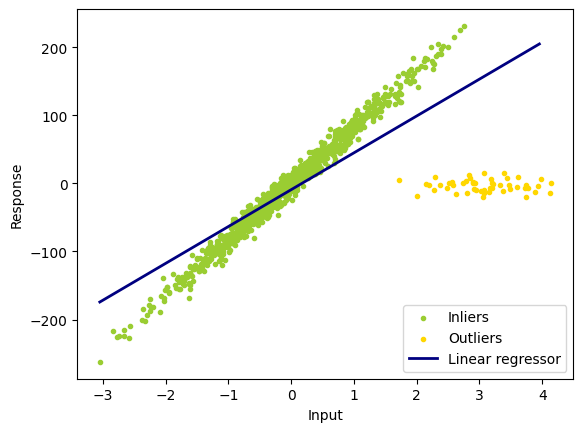

In [37]:
from sklearn import datasets
import matplotlib.pyplot as plt

# Fit line using all data
lr = LinearRegression()
lr.fit(X, y)


# Compare estimated coefficients
print("coefficients (true, linear regression:")
print(coef, lr.weights.flatten())

line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)

lw = 2
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")

plt.legend(loc="lower right")
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

# Real world data

In [53]:
# load data
import pandas as pd

data = pd.read_csv('../data/insurance.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [54]:
data['region'].value_counts()


region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [55]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [56]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [57]:
data["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [58]:
data["region"] = data["region"].astype(str)  # Ensure all values are string
# Perform one-hot encoding using pandas
encoded_df = pd.get_dummies(data["region"], prefix='region', dummy_na=False, drop_first=True)

# Convert encoded columns to integers
encoded_df = encoded_df.astype(int)
# Concatenate the original DataFrame with the encoded DataFrame
data = pd.concat([data, encoded_df], axis=1).drop(columns=['region'])

data.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,16884.92400,0,0,1
1,18,male,33.770,1,no,1725.55230,0,1,0
2,28,male,33.000,3,no,4449.46200,0,1,0
3,33,male,22.705,0,no,21984.47061,1,0,0
4,32,male,28.880,0,no,3866.85520,1,0,0


In [59]:
# one-hot encoding with pandas
data["sex"] = data["sex"].map({'female': 0, 'male': 1})
data["smoker"] = data["smoker"].map({'no': 0, 'yes': 1})
data.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0


In [60]:
data["bmi"].describe()

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

In [61]:
# check for outliers in bmi
data["bmi"] = data["bmi"].apply(pd.to_numeric, errors='coerce')
    
# Calculate Q1, Q3, and IQR
Q1 = data["bmi"].quantile(0.25)
Q3 = data["bmi"].quantile(0.75)
IQR = Q3 - Q1

# Define the upper limit for outliers
upper_limit = Q3 + 1.5 * IQR

print(f'Q1: {Q1}')
print(f'Q3: {Q3}')
print(f'IQR: {IQR}')
print(f'Upper limit: {upper_limit}')

# Remove outliers above the upper limit
df_filtered = data[data["bmi"] <= upper_limit]

df_filtered.info()

Q1: 26.29625
Q3: 34.69375
IQR: 8.3975
Upper limit: 47.290000000000006
<class 'pandas.core.frame.DataFrame'>
Index: 1329 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1329 non-null   int64  
 1   sex               1329 non-null   int64  
 2   bmi               1329 non-null   float64
 3   children          1329 non-null   int64  
 4   smoker            1329 non-null   int64  
 5   charges           1329 non-null   float64
 6   region_northwest  1329 non-null   int64  
 7   region_southeast  1329 non-null   int64  
 8   region_southwest  1329 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 103.8 KB


In [62]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

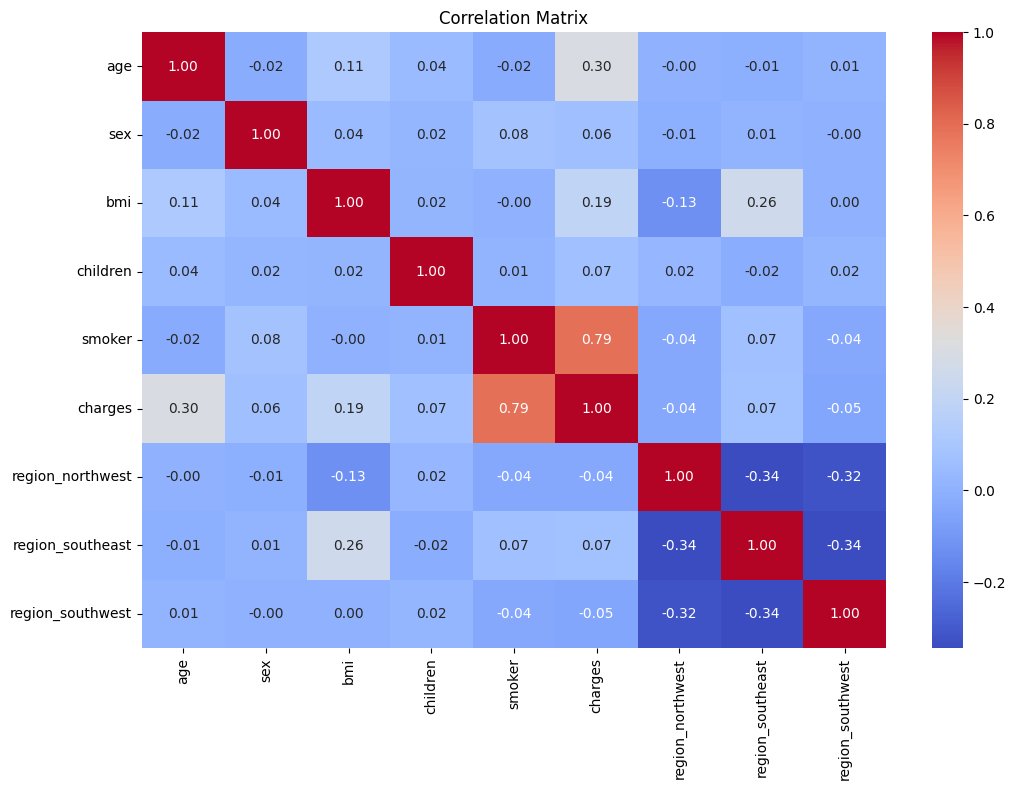

In [63]:
# plot correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [64]:
data["charges"].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

Epoch 0, Loss: 316465680.3779
Epoch 10, Loss: 297014125.8455
Epoch 20, Loss: 278616695.4150
Epoch 30, Loss: 261273389.0865
Epoch 40, Loss: 244984206.8599
Epoch 50, Loss: 229749148.7353
Epoch 60, Loss: 215568214.7126
Epoch 70, Loss: 202441404.7919
Epoch 80, Loss: 190368718.9731
Epoch 90, Loss: 179350157.2563
Epoch 100, Loss: 169385719.6414
Epoch 110, Loss: 160475406.1285
Epoch 120, Loss: 152619216.7175
Epoch 130, Loss: 145817151.4085
Epoch 140, Loss: 140069210.2014
Epoch 150, Loss: 135375393.0963
Epoch 160, Loss: 131735700.0931
Epoch 170, Loss: 129150131.1919
Epoch 180, Loss: 127618686.3927
Epoch 190, Loss: 127119158.8017
Epoch 200, Loss: 126987810.7888
Epoch 210, Loss: 126895728.4599
Epoch 220, Loss: 126817119.8520
Epoch 230, Loss: 126738102.3372
Epoch 240, Loss: 126659243.8064
Epoch 250, Loss: 126581194.0841
Epoch 260, Loss: 126502173.3150
Epoch 270, Loss: 126423311.5299
Epoch 280, Loss: 126344608.7288
Epoch 290, Loss: 126266431.5354
Epoch 300, Loss: 126187691.7997
Epoch 310, Loss: 12

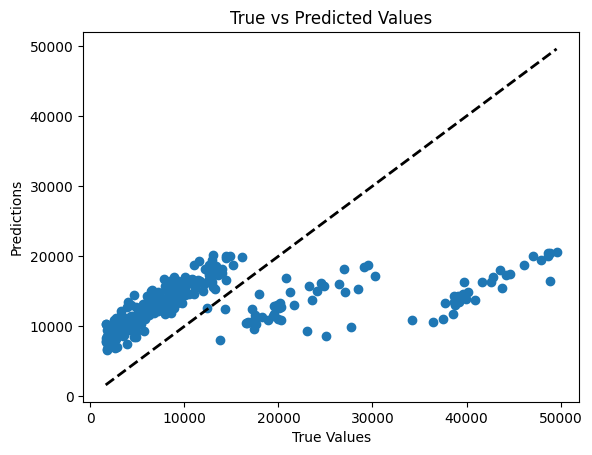

In [65]:
from sklearn.model_selection import train_test_split

# split data into train and test
features = ['age', 'bmi', 'smoker']

X = df_filtered[features].values
y = df_filtered['charges'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# instantiate model
model = LinearRegression()

# fit model
model.fit(x_train, y_train)

# make predictions
predictions = model.predict(x_test)

# calculate mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'R2 Score: {r2:.2f}')
print(f'Coefficients: {model.weights.flatten()}')
print(f'Bias: {model.bias:.2f}')
print(f'Mean Squared Error: {mse:.2f}')

# plot predictions
import matplotlib.pyplot as plt
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.axis('tight')
plt.show()